Run the following line if you don't have any of the libraries

In [ ]:
# %%bash
# pip install statsmodels pandas numpy

In [23]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

import data_prep

In [4]:
data_prep.get_lagged("./data/XLE_energy_etf.csv", n=3)

,Open,High,Low,Close,Adj Close,Volume,Adj Close_1,Adj Close_2,Adj Close_3
Date,,,,,,,,,
2010-01-07,59.740002,60.009998,59.299999,59.910000,45.627445,17449500,45.695988,45.155247,44.789688
2010-01-08,59.700001,60.349998,59.490002,60.299999,45.924469,13344300,45.627445,45.695988,45.155247
2010-01-11,60.689999,60.869999,59.730000,60.220001,45.863533,19459900,45.924469,45.627445,45.695988
2010-01-12,59.299999,59.709999,59.040001,59.349998,45.200943,21510600,45.863533,45.924469,45.627445
2010-01-13,59.320000,59.799999,58.520000,59.570000,45.368496,22137500,45.200943,45.863533,45.924469
...,...,...,...,...,...,...,...,...,...
2020-03-16,27.950001,31.120001,27.670000,27.809999,27.809999,40233600,32.189999,29.469999,33.669998
2020-03-17,28.080000,29.180000,26.950001,28.000000,28.000000,45443600,27.809999,32.189999,29.469999
2020-03-18,26.040001,26.580000,22.879999,23.980000,23.980000,52135800,28.000000,27.809999,32.189999


In [5]:
pd.read_csv("./data/SnP_500.csv", index_col="Date").head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


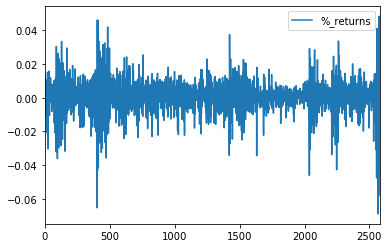

In [6]:
df_perc_returns = data_prep.get_perc_return("./data/SnP_500.csv", column_name="Open")
df_perc_returns.plot()

The way returns are distributed shows a stationary process with no correlation with time 
This also leads us to try out GARCH models since we proabably can model these spikes in volatility.

Following which, we'll look at the full dataset, a concatnation of all the variables together with S&P500

In [7]:
df, psuedo_OOB, OOB = data_prep.split_data("./data/output.csv")

Columns are laballed as such:  VARIABLE_SECTOR

In [ ]:
SNP_daily_ret = (df['Adj Close_SNP500']/df['Adj Close_SNP500'].shift(1)) - 1
SNP_daily_ret = SNP_daily_ret.dropna()

In [ ]:
mod = AutoReg(SNP_daily_ret, 1)
res = mod.fit()
res.summary()

In [ ]:
plot_acf(SNP_daily_ret, lags=30)
plt.show()
plot_pacf(SNP_daily_ret, lags=30)
plt.show()

The ACF shows that after lags of t=2, autocorrelation stays near 0 which means a **MA(2)** model

The PACF shows that after lags of t=2, autocorrelation stays near 0 which means an **AR(2)** model

In [ ]:
mod = AutoReg(SNP_daily_ret, 2)
res = mod.fit()
res.summary()

In [ ]:
ar2 = ARMA(SNP_daily_ret, order=[2,0])
ar2_fit = ar2.fit(disp=0)
print (ar2_fit.summary())
print('\n')

ma2 = ARMA(SNP_daily_ret, order=[0,2])
ma2_fit = ma2.fit(disp=0)
print (ma2_fit.summary())
print('\n')

arma11 = ARMA(SNP_daily_ret, order=[1,1])
arma11_fit = arma11.fit(disp=0)
print (arma11_fit.summary())
print('\n')


AIC values for all the models are extremely similar and hence we look to BIC to decide the best model()

It seems like AR(2) does the best out of all the models.

However, as shown later, adding MA(q) to AR(2) to eliminate autocorrelations yields higher AIC than ARMA(1,1).

In [ ]:
## some usful attributes that might be used in future
"""
arma22_fit.aic
arma22_fit.bic
arma22_fit.fittedvalues  ## return fitted values of the model
arma22_fit.predict(start=2568, end=2570)
"""

In [ ]:
plot_acf(ar2_fit.fittedvalues)

2 lags are present in AR(2) model so we try to fit ARMA(2,2) to rid of the autocorrelations.

In [ ]:
arma22 = ARMA(SNP_daily_ret, order=[2,2])
arma22_fit = arma22.fit(disp=0)
print (arma22_fit.summary())
print('\n')

AIC at -15529.724 is marginally lower than AR(2).

So far, our benchmarked models are:
- AR(2)
- ARMA(1,1)
- ARMA(2,2)

Moving on, we add more variables, to build ADL models that would hopefully beat our benchmark models

We'll start from one industry, build ARMA for models with lags $\in (1,5)$ and then look at their BIC values 

**Note:** we chose lags from 1 to 5 because 5 represents 1 trading week and we want to quickly be able to spot changes

We then choose the lagged_model with lowest BIC (BIC tend to give parsimonous model hence it would better fit our needs to prevent too many variables in our models to prevent overfitting) and iteratively add more industries up to the full model

Afterwords, we rid insignificant variables based on their t-stat. We do this iteratively with the final model till all the variables are significant. 

We note that this method may not be the best method since we didn't cover the full subset to see the lowest AIC/BIC but that is too computationally expensive.

By sampling 50 subsets of **n** variables, it will cover a signiicant subset and such iterative addition of variables is generally accepted in statistics.

In [41]:
## Adding more variables
from statsmodels.tsa.api import VAR
from statsmodels.regression.linear_model import OLS


def build_and_model_VAR(main_df:pd.DataFrame, var2add:list ):
    """
    Arguments:
    main_df - output.csv which has ALL the variables
    var2add - the industry, eg. Pharm. The value MUST be inside the colname 
    """
    temp_df = pd.DataFrame()
    for var in var2add:
        for col in main_df.columns:
            if "Open_"+var in col or "Volume_" + var in col:
                try:
                    temp_df.columns
                except:
                    temp_df = main_df[col]
                else:
                    temp_df = pd.concat([temp_df, main_df[col]], axis=1)
                    
    temp_df['Open_SNP500'] = main_df['Open_SNP500']
    temp_df['Volume_SNP500'] = main_df['Volume_SNP500']
    
    temp_df.index = main_df.index
        
    return temp_df

# lagged_df_exog(industries=["Pharm","Utilities"], col2lag=list(pharm_utils.columns))
def lagged_df_exog(industries:list, target="Open_SNP500", method="ARMA", order=[2,0], remove_vars=[]):
    temp_df = build_and_model_VAR(df, industries)
    y = temp_df[target][order[0]:]
    temp_df = temp_df.drop(target, axis=1)
    og = temp_df.columns 
    temp_df = data_prep.get_lagged_df(temp_df,col2lag=list(temp_df.columns), n=order[0])  ## lags every single var
    
    X_lagged = temp_df.drop(og, axis=1)
    if len(remove_vars) != 0:
        for colname in remove_vars:
            X_lagged = X_lagged.drop(colname, axis=1)
    
    if method == "ARMA":
        model = ARMA(y, order=order, exog=X_lagged)
    elif method == "OLS":
        model = OLS(y, X_lagged)
    else:
        raise Exception("method has to be 'ARMA' or 'OLS'.")
        
    results = model.fit()
    return results

full_industries = ["Pharm", "Semicon", "Industrial", "Energy", "Financial", "Tech", "Utilities", "Consumer"]
def best_lagged_model(industries:list, max_p_lag:int, max_q_lag=0, method="ARMA", start_ic=0, ic_method="BIC", print_summ=False):
    info = []
    ic = start_ic
    for p in range(1, max_p_lag+1):
        for q in range(max_q_lag+1):
            # q can be 0 but p has to be min 1
            try:
                temp_res = lagged_df_exog(industries=industries, order=[p,q])
                if print_summ:
                    print(temp_res.summary())
            except Exception:
                print(Exception)
                continue
            t = {
                    "order": [p,q],
                    "params": dict(temp_res.params),
                    "aic": temp_res.aic,
                    "bic": temp_res.bic,
                }
            info.append(t)
            if ic_method == "BIC":
                temp_ic = temp_res.bic
            elif ic_method == "AIC":
                temp_ic = temp_res.aic
            else:
                raise Exception("ic_method argument has to be 'BIC' or 'AIC'.")
            if ic == 0:  ## first iteration only
                ic = temp_ic
                res = temp_res
            elif temp_ic < ic:
                ic = temp_ic
                res = temp_res
    ## res will have the lowest ic. 
    ## info will be a list of dictionary
    return res, info

We look at the full model first and find the best lag for the full model.

In [30]:
df.columns
full_industries

['Pharm',
 'Semicon',
 'Industrial',
 'Energy',
 'Financial',
 'Tech',
 'Utilities',
 'Consumer']

In [31]:
res_full, info = best_lagged_model(full_industries, max_p_lag=5, max_q_lag=3, print_summ=True)

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2387
Model:                     ARMA(1, 0)   Log Likelihood              -17675.548
Method:                       css-mle   S.D. of innovations            397.813
Date:                Thu, 09 Apr 2020   AIC                          35391.096
Time:                        22:01:03   BIC                          35506.652
Sample:                             0   HQIC                         35433.147
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1887.4073    120.378     15.679      0.000    1651.472    2123.343
Open_Pharm_L1           12.5277      1.875      6.680      0.000       8.852      16.203
Volume_Pharm

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2387
Model:                     ARMA(1, 3)   Log Likelihood              -17669.632
Method:                       css-mle   S.D. of innovations            396.826
Date:                Thu, 09 Apr 2020   AIC                          35385.264
Time:                        22:01:11   BIC                          35518.153
Sample:                             0   HQIC                         35433.623
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1887.4073    124.731     15.132      0.000    1642.938    2131.876
Open_Pharm_L1           12.5277      1.902      6.588      0.000       8.801      16.255
Volume_Pharm

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2386
Model:                     ARMA(2, 1)   Log Likelihood              -17493.190
Method:                       css-mle   S.D. of innovations            369.687
Date:                Thu, 09 Apr 2020   AIC                          35064.380
Time:                        22:01:24   BIC                          35289.698
Sample:                             0   HQIC                         35146.375
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1478.7456    184.938      7.996      0.000    1116.273    1841.218
Open_Pharm_L1            0.1635      2.094      0.078      0.938      -3.942       4.269
Open_Pharm_L

<class 'Exception'>
                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2385
Model:                     ARMA(3, 0)   Log Likelihood              -17372.786
Method:                       css-mle   S.D. of innovations            352.569
Date:                Thu, 09 Apr 2020   AIC                          34857.572
Time:                        22:02:01   BIC                          35181.081
Sample:                             0   HQIC                         34975.302
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1641.6760    230.400      7.125      0.000    1190.101    2093.251
Open_Pharm_L1           -2.6519      2.174     -1.220      0.222      -6.912     

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2385
Model:                     ARMA(3, 2)   Log Likelihood              -17372.986
Method:                       css-mle   S.D. of innovations            352.599
Date:                Thu, 09 Apr 2020   AIC                          34861.972
Time:                        22:02:40   BIC                          35197.036
Sample:                             0   HQIC                         34983.907
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1641.6760    229.889      7.141      0.000    1191.101    2092.251
Open_Pharm_L1           -2.6519      2.113     -1.255      0.209      -6.792       1.489
Open_Pharm_L

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2384
Model:                     ARMA(4, 1)   Log Likelihood              -17196.020
Method:                       css-mle   S.D. of innovations            328.375
Date:                Thu, 09 Apr 2020   AIC                          34542.040
Time:                        22:03:42   BIC                          34975.280
Sample:                             0   HQIC                         34699.707
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2016.8822    284.967      7.078      0.000    1458.356    2575.408
Open_Pharm_L1           -2.3627      2.205     -1.072      0.284      -6.684       1.959
Open_Pharm_L

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2384
Model:                     ARMA(4, 2)   Log Likelihood              -17196.037
Method:                       css-mle   S.D. of innovations            328.377
Date:                Thu, 09 Apr 2020   AIC                          34544.074
Time:                        22:04:19   BIC                          34983.091
Sample:                             0   HQIC                         34703.843
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2016.8822    285.257      7.070      0.000    1457.789    2575.975
Open_Pharm_L1           -2.3627      2.173     -1.087      0.277      -6.622       1.896
Open_Pharm_L

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2384
Model:                     ARMA(4, 3)   Log Likelihood              -17196.109
Method:                       css-mle   S.D. of innovations            328.387
Date:                Thu, 09 Apr 2020   AIC                          34546.218
Time:                        22:04:58   BIC                          34991.011
Sample:                             0   HQIC                         34708.089
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2016.8822    305.098      6.611      0.000    1418.901    2614.863
Open_Pharm_L1           -2.3627      3.157     -0.748      0.454      -8.551       3.826
Open_Pharm_L

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2383
Model:                     ARMA(5, 0)   Log Likelihood              -17129.411
Method:                       css-mle   S.D. of innovations            320.292
Date:                Thu, 09 Apr 2020   AIC                          34442.822
Time:                        22:05:55   BIC                          34974.224
Sample:                             0   HQIC                         34636.216
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1052.2349    309.366      3.401      0.001     445.888    1658.581
Open_Pharm_L1           -0.7063      4.695     -0.150      0.880      -9.909       8.497
Open_Pharm_L

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2383
Model:                     ARMA(5, 1)   Log Likelihood              -17129.412
Method:                       css-mle   S.D. of innovations            320.292
Date:                Thu, 09 Apr 2020   AIC                          34444.825
Time:                        22:07:07   BIC                          34982.004
Sample:                             0   HQIC                         34640.322
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1052.2349    307.825      3.418      0.001     448.908    1655.562
Open_Pharm_L1           -0.7063      3.864     -0.183      0.855      -8.280       6.867
Open_Pharm_L

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2383
Model:                     ARMA(5, 2)   Log Likelihood              -17129.422
Method:                       css-mle   S.D. of innovations            320.293
Date:                Thu, 09 Apr 2020   AIC                          34446.845
Time:                        22:08:23   BIC                          34989.800
Sample:                             0   HQIC                         34644.444
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1052.2349    304.529      3.455      0.001     455.368    1649.102
Open_Pharm_L1           -0.7063      3.798     -0.186      0.852      -8.151       6.738
Open_Pharm_L

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2383
Model:                     ARMA(5, 3)   Log Likelihood              -17129.423
Method:                       css-mle   S.D. of innovations            320.293
Date:                Thu, 09 Apr 2020   AIC                          34448.845
Time:                        22:09:38   BIC                          34997.576
Sample:                             0   HQIC                         34648.546
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1052.2349    303.857      3.463      0.001     456.687    1647.783
Open_Pharm_L1           -0.7063      2.314     -0.305      0.760      -5.241       3.828
Open_Pharm_L

In [42]:
import json
with open('./arma_adl_full.json', 'w') as fout:
    json.dump(info , fout)
    
"""
To load it:
with open('./arma_adl_full.json', 'w') as fin:
    info = json.load(fin)

print(info)
"""

"\nTo load it:\nwith open('./arma_adl_full.json', 'w') as fin:\n    info = json.load(fin)\n\nprint(info)\n"

In [43]:
print(res_full.summary())

                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2384
Model:                     ARMA(4, 0)   Log Likelihood              -17196.017
Method:                       css-mle   S.D. of innovations            328.374
Date:                Thu, 09 Apr 2020   AIC                          34540.033
Time:                        22:13:16   BIC                          34967.497
Sample:                             0   HQIC                         34695.598
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2016.8822    285.434      7.066      0.000    1457.442    2576.322
Open_Pharm_L1           -2.3627      2.208     -1.070      0.285      -6.690       1.965
Open_Pharm_L

Seems like **ARMA(4,0)** fits the full model the best.

The full model has some variables where p-values are not significant. We remove some of those that have the highest p-values (> 0.5). And recompute the ARMA model after removing those variables.

### Extras

In [ ]:
pharm_utils = build_and_model_VAR(df, ["Pharm","Utilities"])
data_prep.get_lagged_df(pharm_utils,col2lag=list(pharm_utils.columns), n=3)

In [ ]:
print(res.aic)
print(res.bic)
print(res.fittedvalues[-10:])

"""
If the model is an ARMAX and out-of-sample forecasting is requested, exog must be given. 
exog must be aligned so that exog[0] is used to produce the first out-of-sample forecast.
"""
# print(res.predict(start=2568, end=2570))

res.summary()

In [ ]:
## forecasting
lag_order = results.k_ar
lag_order
# results.forecast(data.values[-lag_order:], 5)
# results.plot_forecast(10)

# We can do 2 tests as well, Granger casuality and Normality
results.test_causality('Open_SNP500', ['Open_Utilities', 'Open_Pharm'], kind='f')
# results.test_normality()

In [ ]:
df.columns